# Derived variables
#### Author: Rimple Sandhu

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import multiprocessing as mp
import xarray as xr
import geopandas as gpd
import rioxarray as rio
import rasterio
import rasterio as rs
from tqdm import tqdm
from scipy.special import expit
from pathlib import Path
from scipy.ndimage import gaussian_filter

In [4]:
from bayesfilt.models import CVM3D_NL_4, LinearObservationModel
from bayesfilt.filters import UnscentedKalmanFilter
from bayesfilt.telemetry import Telemetry, TelemetryPlotter
from bayesfilt.telemetry import ConstantVelocityResampler, KalmanResampler, ConstantAccelerationResampler
from bayesfilt.telemetry import Data3DEP, DataHRRR
from bayesfilt.telemetry.utils import *
from ssrs.terrain import Terrain
from ssrs.layers import calcOrographicUpdraft_original
from ssrs.terrain import ThreeDEP

In [5]:
telemetry_dir = os.path.join(os.path.abspath(os.path.curdir), 'output', 'telemetry')
output_dir = os.path.join(os.path.abspath(os.path.curdir), 'output')
fig_dir = os.path.join(os.path.abspath(os.path.curdir), 'figs')

In [12]:
fpath = os.path.join(telemetry_dir, 'csg_ge_vr.prq_tracks')
df = pd.read_parquet(fpath)
df_bool = df['Group'].isin(['pa'])
idf = df[df_bool]
csg_vr = Telemetry(
    times=idf['TimeUTC'],
    times_local=idf['TimeLocal'],
    lons=idf['Longitude'],
    lats=idf['Latitude'],
    zlocs=idf['Altitude'],
    animalids=idf['AnimalID'],
    regions=idf['Group'],
    df_add=idf,
    out_dir=output_dir,
)
csg_vr.partition_into_subdomains()
csg_vr.info()

Telemetry: Region pa = 531/891 domains contain data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 594760 entries, 389306 to 984065
Data columns (total 46 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   TimeUTC                   594760 non-null  datetime64[ns]
 1   Latitude                  594760 non-null  float64       
 2   Longitude                 594760 non-null  float64       
 3   Age                       594760 non-null  category      
 4   AltDiff                   594760 non-null  float32       
 5   Altitude                  594760 non-null  float32       
 6   AnimalID                  594760 non-null  category      
 7   BoundaryLayerHeight       140182 non-null  float32       
 8   DistDiff                  594760 non-null  float32       
 9   DomainID                  594760 non-null  category      
 10  ErrorHDOP                 594760 non-null  float32       
 11  ErrorVDO

In [7]:
fpath = os.path.join(telemetry_dir, 'csg_ge_vr.prq_tracks_ca')
df = pd.read_parquet(fpath)
df_bool = (df['Group'].isin(['pa'])) & (df['TrackID'] > 0)
idf = df[df_bool]
csg_cr = Telemetry(
    times=idf['TimeUTC'],
    times_local=idf['TimeLocal'],
    lons=idf['Longitude'],
    lats=idf['Latitude'],
    zlocs=idf['Altitude'],
    animalids=idf['AnimalID'],
    regions=idf['Group'],
    df_add=idf,
    out_dir=output_dir,
)
csg_cr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747873 entries, 674382 to 1422254
Data columns (total 37 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   TimeUTC            747873 non-null  datetime64[ns]
 1   Latitude           747873 non-null  float32       
 2   Longitude          747873 non-null  float32       
 3   TrackTimeElapsed   747873 non-null  float32       
 4   PositionX          747873 non-null  float64       
 5   PositionX_var      747873 non-null  float32       
 6   VelocityX          747873 non-null  float32       
 7   VelocityX_var      747873 non-null  float32       
 8   AccelerationX      747873 non-null  float32       
 9   AccelerationX_var  747873 non-null  float32       
 10  TrackID            747873 non-null  int16         
 11  PositionY          747873 non-null  float64       
 12  PositionY_var      747873 non-null  float32       
 13  VelocityY          747873 non-null  fl

In [8]:
fpath = os.path.join(telemetry_dir, 'csg_ge_vr.prq_tracks_cvm_annotated')
df = pd.read_parquet(fpath)
df_bool = (df['Group'].isin(['pa'])) & (df['TrackID'] > 0)
idf = df[df_bool]
csg_cvm = Telemetry(
    times=idf['TimeUTC'],
    times_local=idf['TimeLocal'],
    lons=idf['Longitude'],
    lats=idf['Latitude'],
    zlocs=idf['Altitude'],
    animalids=idf['AnimalID'],
    regions=idf['Group'],
    df_add=idf,
    out_dir=output_dir,
)
csg_cvm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747873 entries, 670792 to 1418664
Data columns (total 95 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   TimeUTC                   747873 non-null  datetime64[ns]
 1   Latitude                  747873 non-null  float32       
 2   Longitude                 747873 non-null  float32       
 3   Age                       747873 non-null  category      
 4   Altitude                  747873 non-null  float32       
 5   Altitude_var              747873 non-null  float32       
 6   AnimalID                  747873 non-null  category      
 7   BoundaryLayerHeight       747873 non-null  float32       
 8   DriftX                    747873 non-null  float32       
 9   DriftX_var                747873 non-null  float32       
 10  DriftY                    747873 non-null  float32       
 11  DriftY_var                747873 non-null  float32       
 

In [16]:
csg_cvm.df.TrackID.unique(), csg_vr.df.TrackID.nunique()

(array([289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301,
        302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314,
        315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327,
        328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340,
        341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353,
        354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366,
        367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379,
        380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392,
        393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405,
        406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418,
        419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431,
        432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444,
        445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457,
        458, 459, 460, 461, 462, 463, 464, 465, 466

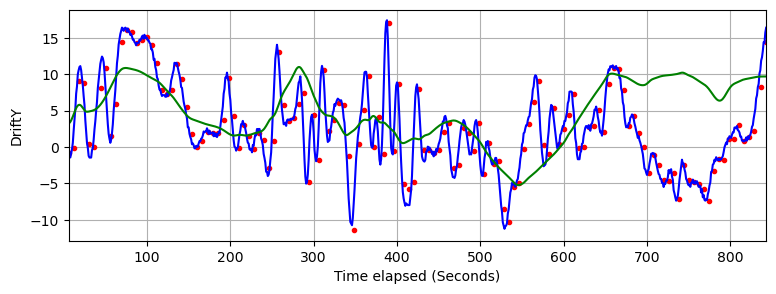

In [40]:
fig, ax = plt.subplots(figsize=(9,3))
track_id = 842
dftrack = csg_vr.df[csg_vr.df['TrackID']==track_id]
cname='VelocityY'
plotter_vr = TelemetryPlotter(csg_vr)
plotter_vr.plot_track_in_time(track_id, cname, '.r', ax=ax)
plotter_cr = TelemetryPlotter(csg_cr)
plotter_cr.plot_track_in_time(track_id, cname, '-b', ax=ax)
plotter_cvm = TelemetryPlotter(csg_cvm)
plotter_cvm.plot_track_in_time(track_id, 'DriftY', '-g')
#ax.set_xlim([150,190])
ax.grid(True)

In [ ]:
csg_cr.df.VelocityHor.hist(bins=100, range=(0,50), density=True)
ibool = (csg_vr.df['Group']=='pa') & (csg_vr.df['TrackID']>0)
csg_vr.df.loc[ibool,'VelocityHor'].hist(bins=100, range=(0,50), density=True)

In [ ]:
csg_cr.df.VelocityVer.hist(bins=100, range=(0,10), density=True)
ibool = (csg_vr.df['Group']=='pa') & (csg_vr.df['TrackID']>0)
csg_vr.df.loc[ibool,'VelocityVer'].hist(bins=100, range=(0,10), density=True)

In [ ]:
csg_vr.df.loc[ibool,'TrackID'].unique()

In [ ]:
dftrack.columns

In [ ]:
idftrack= csg_cr.df[csg_cr.df['TrackID']==track_id]
mm = CVM3D_NL_4()
mm.dt = 1.
mm.phi = {
    'eta_hor': 3.,
    'sigma_log_tau_hor': 0.1,
    'sigma_mu_hor': 0.2,
    'sigma_omega': 0.01,
    'eta_ver': 1.,
    'sigma_log_tau_ver': 0.1,
    'sigma_mu_ver': 0.04
}
om = LinearObservationModel(
    nx=mm.nx,
    observed_state_inds=[0, 1, 6]
)
ukf = UnscentedKalmanFilter(
    nx=mm.nx,
    ny=om.ny,
    dt=mm.dt,
    dt_tol=0.5,
    pars={'alpha': .00001, 'beta': 2., 'kappa': -9, 'use_cholesky': True},
    fun_f=mm.func_f,
    fun_Q=mm.func_Q,
    mat_H=om.H,
    state_names=mm.state_names,
    verbose=False
)
ukf.objectid = track_id
start_state_dict = {
    'PositionX': (idftrack['PositionX'].iloc[0], 4.),
    'PositionY': (idftrack['PositionY'].iloc[0], 4.),
    'VelocityX': (idftrack['VelocityX'].iloc[0], 2.),
    'VelocityY': (idftrack['VelocityY'].iloc[0], 2.),
    'DriftX': (idftrack['VelocityX'].iloc[0], 2.),
    'DriftY': (idftrack['VelocityY'].iloc[0], 2.),
    'PositionZ': (idftrack['Altitude'].iloc[0], 5.),
    'VelocityZ': (idftrack['VelocityVer'].iloc[0], 2.),
    'DriftZ': (0., 1.),
    'Omega': (0., 0.05),  # 0.1 is 6 deg
    'LogTauVer': (-2, 0.5),
    'LogTauHor': (-2, 1.)
}
list_of_times = list(idftrack[['TrackTimeElapsed']].values[:, 0])
ukf.initiate_state(start_state_dict)
ukf.initiate(t0=list_of_times[0])
observation_vars = {
    'PositionX': idftrack[['PositionX_var']].values.squeeze() * (2.5**2) * 2,
    'PositionY': idftrack[['PositionY_var']].values.squeeze() * (2.5**2) * 2,
    'Altitude': idftrack[['Altitude_var']].values.squeeze() * (2.5**2) * 1
}
list_of_observation_covs = [
    np.diag(ix) for ix in np.array(list(observation_vars.values())).T]
list_of_observations = list(idftrack[observation_vars.keys()].values)

try:
    ukf.filter(list_of_times[1:], list_of_observations[1:],
               list_of_observation_covs[1:])
    ukf.smoother()
    # if np.amax(np.abs(kf.get_mean('Omega'))) > 2.:
    #     raise ValueError
    # print(f'{track_id}-good', flush=True)
except:
    # pass
    print(f'{track_id}-issue', flush=True)
else:
    cvm_fpath = os.path.join(
        TRACK_DIR, f'ukfnew_cvm3d_{ukf.objectid}.pickle')
    with open(cvm_fpath, "wb") as fobj:
        pickle.dump(ukf, fobj)
return ukf


In [ ]:
ukf.plot_state_mean('PositionX', smoother=True)

In [ ]:
dftrack = df[df['TrackID']==1]
rs.resample(
    times=dftrack['TrackTimeElapsed'],
    locs = dftrack['PositionX'],
    error_std = dftrack['ErrorHDOP']*2.5,
    start_state_std = [5.,2.],
    object_id = dftrack['TrackID'].iloc[0]
)

In [ ]:
df['TrackID'].min()

In [ ]:
list_of_tracks = df.loc[df['Group']=='pa','TrackID'].unique()
list_of_dftrack = [df[df['TrackID']==ix] for ix in list_of_tracks if ix !=0]

In [ ]:
len(list_of_dftrack)

In [ ]:
for dftrack in list_of_dftrack[:2]:
    track_id = dftrack['TrackID'].iloc[0]
    print(f'{track_id}-', end="")
    rs_x = ConstantVelocityResampler(dt=1.,error_strength = 0.1, flag='X')
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs = dftrack['PositionX'].values,
        error_std = dftrack['ErrorHDOP']*2.5,
        start_state_std = [5.,2.],
        object_id = track_id
    )
    rs_y = ConstantVelocityResampler(dt=1.,error_strength = 0.1, flag='Y')
    rs_y.resample(
        times=dftrack['TrackTimeElapsed'],
        locs = dftrack['PositionY'],
        error_std = dftrack['ErrorHDOP']*2.5,
        start_state_std = [5.,2.],
        object_id = track_id
    )
    rs_z = ConstantVelocityResampler(dt=1.,error_strength = 0.1, flag='Z')
    rs_z.resample(
        times=dftrack['TrackTimeElapsed'],
        locs = dftrack['Altitude'],
        error_std = dftrack['ErrorVDOP']*2.5,
        start_state_std = [5.,2.],
        object_id = track_id
    )
    sdf = pd.concat((rs_x.kf.df, rs_y.kf.df), axis=1, join='inner')
    sdf = sdf.loc[:, ~sdf.columns.duplicated()]
    cols_to_drop = [ix for ix in sdf.columns if '_var' in ix]
    cols_to_drop += [ix for ix in sdf.columns if 'Metric' in ix]
    sdf.drop(columns=cols_to_drop, inplace=True)
    sdf['TimeUTC'] = pd.date_range(
        start=dftrack['TimeUTC'].iloc[0],
        periods=len(sdf),
        freq=str(rs_x.mm.dt) + "S"
    )
    sdf['TimeLocal'] = pd.date_range(
        start=dftrack['TimeLocal'].iloc[0],
        periods=len(sdf),
        freq=str(rs_x.mm.dt) + "S"
    )

In [ ]:
sdf

In [ ]:
dftrack.TimeLocal

In [ ]:
dftrack.TrackTimeElapsed.describe()

In [ ]:
idf = vdf[vdf['Group'].isin(['hr'])]
csg = Telemetry(
    times = idf['TimeUTC'],
    times_local = idf['TimeLocal'],
    lons = idf['Longitude'],
    lats = idf['Latitude'],
    zlocs=idf['Altitude'],
    animalids=idf['AnimalID'],
    regions=idf['Group']
)
csg.df['Heading_TU'] = idf['HeadingHor_TU']

In [ ]:
csg.ignore_data_based_on_vertical_speed(max_change=35.)
csg.ignore_data_based_on_horizontal_speed(min_speed=0.25)
csg.sort_df(['Group', 'AnimalID','TimeUTC'])
csg.annotate_track_info(min_time_interval=10, min_time_duration=5*60, min_num_points=60, time_col = 'TimeLocal')

In [ ]:
csg.annotate_hrrr_data(ncores=24,tracks_only=True)
csg.df['WindSpeed_80m'] = csg.df['WindSpeedU_10m']**2 + csg.df['WindSpeedV_10m']**2
csg.df['WindDirection_80m'] = get_wind_direction(csg.df['WindSpeedU_10m'], csg.df['WindSpeedV_10m'])

In [ ]:
gf_func = partial(gaussian_filter, sigma=10, mode='constant', truncate=5, cval=0)
fn = partial(csg.annotate_3dep_data, heading_col = 'Heading_TU', tracks_only=True, filter_func=gf_func)
fn(flag = '', dist_away = 0., angle_away = 0.)
fn(flag = '_d50h0', dist_away = 50., angle_away = 0.)

In [ ]:
def compute_oro(flag):
    jname = f'OroUpdraftSmooth_80m{flag}'
    csg.df[jname] = np.cos(np.radians(csg.df['WindDirection_80m']))*csg.df[f'OroTerm1{flag}']
    csg.df[jname] += np.sin(np.radians(csg.df['WindDirection_80m']))*csg.df[f'OroTerm2{flag}']
    csg.df[jname] *= csg.df['WindSpeed_80m']
    csg.df[f'{jname}_mod'] = expit(2*(csg.df[jname]-0.75))
    csg.df[jname].clip(lower=0., inplace=True)
    csg.df[f'OroUpdraft_80m{flag}'] = calcOrographicUpdraft_original(
            wspeed=csg.df['WindSpeed_80m'].values,
            wdirn=csg.df['WindDirection_80m'].values,
            slope=csg.df[f'GroundSlope{flag}'].values,
            aspect=csg.df[f'GroundAspect{flag}'].values,
            res_terrain=10.,
            res=10.
    )
compute_oro('')
compute_oro('_d50h0')

In [ ]:
csg.info()

In [ ]:
fig, ax = plt.subplots(figsize=(5,3))
flag='_d50h0'
df.loc[df.TrackID>0,f'OroUpdraftSmooth_80m{flag}'].hist(bins=100, ax=ax, density=True, range=(0.001,10), histtype='step')
df.loc[df.TrackID>0,f'OroUpdraft_80m{flag}'].hist(bins=100, ax=ax, density=True, range=(0.001,10),histtype='step')

In [ ]:
csg_vr.df.columns

In [ ]:
csg_vr.df_subdomains

In [ ]:
csg_vr.annotate_3dep_data()

In [ ]:
idomain = 'pa29'
ids = csg_vr.df_subdomains.loc[idomain].threedep.ds
idsg = csg_vr.df_subdomains.loc[idomain].threedep.ds_geo
xx, yy = np.meshgrid(ids.x, ids.y, indexing='xy')

In [ ]:
ids['TRI'] = (('y', 'x'), calcTRI(ids['GroundElevation'].values, window=9))

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
cm = ax.pcolormesh(xx, yy, ids.TRI.values)
plt.colorbar(cm, ax=ax)
ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
cm = ax.pcolormesh(xx, yy, ids.GroundElevation.values)
plt.colorbar(cm, ax=ax)
ax.set_aspect('equal')

In [ ]:
def calcTRI(hgt,window=None,footprint=None):
    '''
    Terrain Ruggedness Index
    Riley, S. J., DeGloria, S. D., & Elliot, R. (1999). Index that 
        quantifies topographic heterogeneity. intermountain Journal 
        of sciences, 5(1-4), 23-27.
    
    hgt : array
        Array of heights over which TRI will be calculated
    window : int
        Length of window in x and y direction. Must be odd.
    '''
    import xarray as xr
    from scipy.ndimage import generic_filter

    # Window setup:
    if footprint is not None:
        assert window is None, 'Must specify either window or footprint'
        window = np.shape(footprint)[0]
    
    assert (window/2.0) - np.floor(window/2.0) != 0.0, 'window must be odd...'
    Hwindow = int(np.floor(window/2))
    
    # Type and dimension check:
    if isinstance(hgt,(xr.Dataset,xr.DataArray,xr.Variable)):
        hgt = hgt.data    
    assert len(np.shape(hgt)) == 2, 'hgt must be 2-dimensional. Currently has {} dimensions'.format(len(np.shape(hgt)))
    
    ny,nx = np.shape(hgt)
    
    def tri_filt(x):
        middle_ind = int(len(x)/2)
        return((sum((x - x[middle_ind])**2.0))**0.5)
    
    if footprint is None:
        tri = generic_filter(hgt,tri_filt, size = (window,window))
    else:
        tri = generic_filter(hgt,tri_filt, footprint=footprint)
    
    return tri


In [ ]:
ll_bound = csg.df_subdomains.loc[idomain].threedep.lonlat_bound
#ll_bound = [-106.1,   41.7, -105.7,   42.]
#ll_bound = [-105.9,   41.7, -105.7,   41.9]
print(ll_bound)
terrain = Terrain(ll_bound, output_dir, print_verbose=True)
terrain.download('DEM')
print(terrain.get_raster_fpath('DEM'))

In [ ]:
fpath = '/lustre/eaglefs/projects/car/rsandhu/csg_data/output/wms_raw_3.tif'
#dsgr = rio.open_rasterio(fpath)
dsgr = rio.open_rasterio(terrain.get_raster_fpath('DEM'))
dsgr = dsgr.to_dataset(name='GroundElevation').squeeze()

In [ ]:
src = rs.open(fname)
plt.imshow(src.read()[0])

In [ ]:
not np.any(src.read())

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#plotter.plot_track_in_space(55, ax=ax)
xxg, yyg = np.meshgrid(dsgr.x, dsgr.y, indexing='xy')
cm = ax.pcolormesh(xxg, yyg, dsgr.GroundElevation.values)
plt.colorbar(cm, ax=ax)
xlocs = csg.df.loc[csg.df.DomainID==idomain, 'Longitude'] 
ylocs = csg.df.loc[csg.df.DomainID==idomain, 'Latitude'] 
ax.plot(xlocs, ylocs, '.r', markersize=0.1)
ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#plotter.plot_track_in_space(55, ax=ax)
xxg, yyg = np.meshgrid(dsgr.x, dsgr.y, indexing='xy')
cm = ax.pcolormesh(xxg, yyg, dsgr.GroundElevation.values)
plt.colorbar(cm, ax=ax)
xlocs = csg.df.loc[csg.df.DomainID==idomain, 'Longitude'] 
ylocs = csg.df.loc[csg.df.DomainID==idomain, 'Latitude'] 
ax.plot(xlocs, ylocs, '.r', markersize=0.1)
ax.set_aspect('equal')

In [ ]:
dsgr.GroundElevation

In [ ]:
fig, ax = plt.subplots(figsize=(6,5))
#plotter.plot_track_in_space(55, ax=ax)
xxg, yyg = np.meshgrid(idsg.x, idsg.y, indexing='xy')
cm = ax.pcolormesh(xxg, yyg, idsg.GroundElevation.values)
plt.colorbar(cm, ax=ax)
xlocs = csg.df.loc[csg.df.DomainID==idomain, 'Longitude'] 
ylocs = csg.df.loc[csg.df.DomainID==idomain, 'Latitude'] 
ax.plot(xlocs, ylocs, '.r', markersize=0.1)
ax.set_aspect('equal')

In [ ]:
idsg = rio.open_rasterio(csg.df_subdomains.loc[idomain].threedep.terrain.get_raster_fpath('DEM')).to_dataset(name='GroundElevation').squeeze()

In [ ]:
csg.df_subdomains.loc['hr41'].threedep

In [ ]:
ids['GroundSlope'].plot()

In [ ]:
ids['GroundAspect'].plot()

In [ ]:
wms

In [ ]:
import glob, os
os.chdir('/lustre/eaglefs/projects/car/rsandhu/csg_data/output/data_hrrr/')
for file in glob.glob("2016-11-16*"):
    print(file)

In [ ]:
ds = xr.open_mfdataset('/lustre/eaglefs/projects/car/rsandhu/csg_data/output/data_hrrr/2016-11-16*.nc', 
                  combine='nested', concat_dim=('time'))
# for _, iname in DataHRRR.variables.items():
#     ds[iname] = ds[iname].bfill(dim='time')

In [ ]:
ds.time.values

In [ ]:
_, ix = np.unique(ds.y.values, return_counts=True)
np.amin(ix), np.amax(ix)

In [ ]:
ds['time'][1] = ds['time'][4].values
ds.time.values

In [ ]:
time_utc = ds['time'][0].values
time_str = np.datetime_as_string(time_utc, unit='h', timezone='UTC')

#self.printit(f'Trying {time_str}..')
try:
    hobj = HRRR(time_utc)
    ivar, ivarname = list(DataHRRR.variables.items())[0]
    ids = hobj.get_xarray_for_regex(ivar, remove_grib=False)
#     ids = self.add_xy_coords_to_hrrr_xarray(ids)
#     ids = self.refine_hrrr_xarray(ids)
#     ids = ids.rename({list(ids.keys())[0]: ivarname})
except Exception as _:
    success = False
    self.printit(f'{time_str}: aws-issue')
else:
    for ivar, iname in DataHRRR.variables.items():
        try:
            tds = hobj.get_xarray_for_regex(ivar, remove_grib=False)
            idata = tds[list(tds.keys())[0]].values
            if idata.shape != (ids.y.size, ids.x.size):
                raise ValueError
            ids[iname] = (('y', 'x'), idata)
            ids[iname].attrs = tds[list(tds.keys())[0]].attrs
        except ValueError as _:
            success = False
            self.printit(f' {time_str}-{iname}-problem!')
            #idata = np.full((ids['y'].size, ids['x'].size), np.nan)
            #ids[iname] = (('y', 'x'), idata)
    
    #ids = ids.expand_dims(dim='time')

In [ ]:
ids

In [ ]:
ids['time'] = ds['time'][4].values
ids

In [ ]:
ds['time'][4].values
#ids

In [ ]:
ds['WindSpeedU_10m'].isel(time=4).plot()

In [ ]:
for ix, iy, iz in zip(unique, counts, idx):
    if iz > 1:
        print(ix, iy, iz)

In [ ]:
self = csg
locs_hrrr = ccrs.CRS(DataHRRR.hrrr_crs).transform_points(
            x=self.df[self.lon_col].values,
            y=self.df[self.lat_col].values,
            src_crs=ccrs.CRS(self.geo_crs)
        )
final_bool = csg.df[csg.t_col].astype('datetime64[D]') == '2016-11-16'
final_bool = final_bool & (csg.df[csg.trackid_col] > 0)
print(final_bool.sum())
xlocs = locs_hrrr[final_bool, 0]
ylocs = locs_hrrr[final_bool, 1]
tlocs = self.df.loc[final_bool, self.t_col].values
lons = self.df.loc[final_bool, self.lon_col].values
_, idx = np.unique(xlocs, return_index=True)
_, idy = np.unique(ylocs, return_index=True)
indices = np.intersect1d(idx, idy)
print(indices.size)

In [ ]:
out_dict = {}
for _, iname in DataHRRR.variables.items():
    print(iname)
    ds[iname] = ds[iname].interpolate_na(dim='time')
    out_dict[iname] = ds[iname].interp(
        time=xr.DataArray(tlocs, dims=['points']),
        x=xr.DataArray(xlocs, dims=['points']),
        y=xr.DataArray(ylocs, dims=['points']),
        #method='linear',
        #kwargs={'fill_value': None},
        # kwargs={'fill_value': 'extrapolate'}
    ).values.astype('float32')

In [ ]:
tlocs[:2], xlocs[:2], ylocs[:2]

In [ ]:
ccrs.CRS(DataHRRR.hrrr_crs)

In [ ]:
day_string = '2017-12-25'
fname = csg.hrrr_dir / f'{day_string}*.nc'
ds = xr.open_mfdataset(fname.as_posix())

In [ ]:
ds.load().isnull().sum().values()

In [ ]:
fname.as_posix()

In [ ]:
xr.open_mfdataset('/lustre/eaglefs/projects/car/rsandhu/csg_data/output/data_hrrr/2017-12-25*.nc')

In [ ]:
unique_times = get_unique_times(csg.df.loc[csg.df.TrackID > 0,'TimeUTC'])
for itime in tqdm(unique_times, total=len(unique_times), desc='Test', position=0, leave=True):
    hrrr = DataHRRR(time_utc=itime, out_dir=csg.out_dir / 'data_hrrr')
    hrrr.download()

In [ ]:
hrrr = DataHRRR(time_utc=unique_times[0], out_dir=csg.out_dir / 'data_hrrr')

In [ ]:
hrrr.filepath

In [ ]:
ds = hrrr.download(
    variables={
    ':UGRD:10 m': 'WindSpeedU_10m',
    ':VGRD:10 m': 'WindSpeedV_10m'
    }
)

In [ ]:
unique_times = get_unique_times(csg.df.loc[csg.df.TrackID > 0,'TimeUTC'])

In [ ]:
variables={
    ':UGRD:10 m': 'WindSpeedU_10m',
    ':VGRD:10 m': 'WindSpeedV_10m'
    }
hrrr_obj = HRRR(hrrr.time_utc)
ivar, ivarname = list(variables.items())[0]
ids = hrrr_obj.get_xarray_for_regex(ivar, remove_grib=False)
ids = hrrr.add_xy_coords_to_hrrr_xarray(ids)
ids = hrrr.refine_hrrr_xarray(ids)
ids = ids.rename({list(ids.keys())[0]: ivarname})

In [ ]:
for ivar, iname in variables.items():
    ds_tmp = hrrr_obj.get_xarray_for_regex(ivar, remove_grib=False)
    idata = ds_tmp[list(ds_tmp.keys())[0]].values
    print(idata.shape, ids.x.size)
    if idata.shape != (ids.y.size, ids.x.size):
        raise ValueError
    ids[iname] = (('y', 'x'), idata)
    ids[iname].attrs = ds_tmp[list(ds_tmp.keys())[0]].attrs
ids[iname].attrs = {k: v for k, v in ids[iname].attrs.items() if 'grib' not in k.lower()}
ids = ids.expand_dims(dim='time')

In [ ]:
ids

In [ ]:
dep3 = Data3DEP(
            lonlat_bounds=[-113.50789513,37.7201062,-113.19929979,37.93807586],
            resolution=10,
            proj_crs='ESRI:102008',
            out_dir=output_dir
        )

In [ ]:
csg.proj_crs.proj4_init

In [ ]:
ccrs.CRS('ESRI:102008').transform_points(x=np.array([-100]),y=np.array([40]), src_crs=csg.geo_crs)

In [ ]:
csg.partition_into_subdomains()

In [ ]:
for idx, irow in [-113.50789513   37.72010623 -113.19929979   37.93807586]csg.df_subdomains.iloc[:2].iterrows():
    print(irow[['lonmin', 'latmin', 'lonmax', 'latmax']].values)

In [ ]:
csg.download_3dep_data(resolution=10., num_cores=36)

In [ ]:
csg.annotate_3dep_data(flag="", num_cores=36, dist_away=0., angle_away=0., heading_col = 'Heading_TU')
csg.annotate_3dep_data(flag="_d50", num_cores=36, dist_away=50., angle_away=0., heading_col = 'Heading_TU')

In [ ]:
csg.df.info()

In [ ]:
csg.df.GroundElevation.hist(bins=100)

In [ ]:
csg

In [ ]:
#for iname in list(ids.keys()):
ids[iname].values.shape

In [ ]:
import sys
sys.getsizeof(xx)/1024

In [ ]:
from ssrs import HRRR

In [ ]:
HRRR.

In [ ]:
type(csg.df_subdomains.loc['hr0','threedep'].ds)

In [ ]:
for idx, irow in csg.df_subdomains.iloc[:1].iterrows():
    print(idx)
    ibnd = irow[['lonmin', 'latmin', 'lonmax', 'latmax']].values
    lon_bool = csg.df[csg.lon_col].between(ibnd[0], ibnd[2])
    lat_bool = csg.df[csg.lat_col].between(ibnd[1], ibnd[3])
    xlocs = csg.df.loc[lon_bool & lat_bool, csg.x_col].values
    ylocs = csg.df.loc[lon_bool & lat_bool, csg.y_col].values
    xlocs_xr = xr.DataArray(xlocs, dims=['points'])
    ylocs_xr = xr.DataArray(ylocs, dims=['points'])
    ids = csg.df_subdomains.loc[idx, 'threedep'].ds
    out_dict = ids.interp(
        x=xlocs_xr,
        y=ylocs_xr,
        method='linear',
        kwargs={'fill_value': None},
    )

In [ ]:
list(out_dict.keys())

In [ ]:
np.sin(np.arctan2(1,0))

In [ ]:
tbar = partial(tqdm.tqdm, total=10, desc='3DEP')
for ix in tbar(range(10)):
    print(ix)

In [ ]:
func(*[1,2])

In [ ]:
lonlat_bounds = csg.df_subdomains[['lonmin','latmin', 'lonmax','latmax']].iloc[20].values
dp3 = Terrain3DEP(lonlat_bounds, output_dir)

In [ ]:
unique_times = get_unique_times(csg.df.TimeUTC)
type(unique_times[0])

In [ ]:
dp3.ds_proj.GroundElevation.plot()

In [ ]:
dp3.ds_proj.GroundAspect.plot()

In [ ]:
type(rio.crs.crs_from_user_input(csg.proj_crs.proj4_init))

In [ ]:
rio.crs.crs_from_user_input(csg.proj_crs.proj4_init) == csg.proj_crs

In [ ]:
# usa = gpd.read_file(os.path.join(data_dir, 'maps', 'usa_states', 'cb_2018_us_state_20m.shp'))
# usa_crs = usa.to_crs(crs=csg.geo_crs)
# fig, ax = plt.subplots(figsize=(8,8))
# usa_crs.boundary.plot(ax=ax, linewidth=0.3)
# # for idomain in [ix for ix in csg.df_subdomains.index.tolist() if 'pa' in ix]:
# #     csg.plot_subdomain(idomain, '.k', ax=ax, markersize=0.1)
# # ax.set_xlim([-2.5e6, 2.5e6])
# # ax.set_ylim([-2e6, 1.5e6])

In [ ]:
from ssrs.terrain import Terrain

In [ ]:
csg.proj_crs.transform_point(x=-103.551552, y=42.586796, src_crs=csg.geo_crs)

In [ ]:
csg.df.iloc[11123]

In [ ]:
xx = (0>1)
print(xx)
if (xx) == True:
    print('i am here')

In [ ]:
Terrain.valid_layers

In [ ]:
lonlat_bound = [-102, 43,-101.9,43.1]
region = Terrain(lonlat_bound, telemetry_dir, print_verbose=True)
region.download('DEM')

In [ ]:
region.get_raster_fpath

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
csg.plot_track_in_time(10, 'PositionY', '-r')
fig.tight_layout()

In [ ]:
rs_x = ConstantVelocityResampler(dt=1., error_strength=0.8, dim_name='X')
rs_y = ConstantVelocityResampler(dt=1., error_strength=0.8, dim_name='Y')
rs_z = ConstantVelocityResampler(dt=1.,error_strength=0.2, dim_name='Z')

In [ ]:
rs_y

In [ ]:
rs.resample(
    times = csg.df_track(10)['TrackTimeElapsed'],
    positions = csg.df_track(10)['PositionX'],
    error_std = csg.df_track(10)['ErrorHDOP']*2.5,
    start_state_std = [10,5,2],
    object_id = 10
)

In [ ]:
rs.kf.dfs.info()

In [ ]:
fig, ax = plt.subplots(figsize=(8,3))
state = 'PositionX'
csg.plot_track_in_time(10, state, '-r')
rs.kf.plot_state_mean(state, '-b')

In [ ]:
csg.plot_track_in_time(20, col_name = 'PositionX')

In [ ]:
csg.df.TrackTimeElapsed.astype('float32').memory_usage()/1024/1024

In [ ]:
csg.df.TrackTimeElapsed.astype('Sparse[float32]').memory_usage()/1024/1024

In [ ]:
csg.df.TrackTimeElapsed.info()

In [ ]:
csg.df.

In [ ]:
csg.df.loc[csg.df['DomainID']=='wy12','PositionX'].between(*csg.df_subdomains.loc['wy12',['xmin','xmax']]).all()

In [ ]:
csg.df[csg.domain_col] = -1
iregion = 'hr'
x_width = 20 * 1000
y_width = 20 * 1000
pad = 1. * 1000
rbool = csg.df[csg.region_col] == iregion
x_bound = [csg.df.loc[rbool, csg.x_col].min() - pad,
           csg.df.loc[rbool, csg.x_col].max() + pad]
y_bound = [csg.df.loc[rbool, csg.y_col].min() - pad,
           csg.df.loc[rbool, csg.y_col].max() + pad]
x_nblocks = int(np.ceil((x_bound[1] - x_bound[0]) / x_width))
y_nblocks = int(np.ceil((y_bound[1] - y_bound[0]) / y_width))
x_edges = np.linspace(x_bound[0], x_bound[0] + x_width * x_nblocks, x_nblocks+1)
y_edges = np.linspace(y_bound[0], y_bound[0] + y_width * y_nblocks, y_nblocks+1)
x_bins = np.digitize(csg.df.loc[rbool, csg.x_col], x_edges)
y_bins = np.digitize(csg.df.loc[rbool, csg.y_col], y_edges)
uniq, domain_id = np.unique(np.vstack((x_bins, y_bins)), axis=1,
                            return_inverse=True)
# bound = [x_bins[]]
csg.df.loc[rbool, csg.domain_col] = domain_id
istr = f'{uniq.shape[1]}/{x_nblocks*y_nblocks} have data'
#csg.log.info(f'Region {iregion}: {istr}')
csg.df[csg.domain_col] = csg.df[csg.domain_col].astype('category')

In [ ]:
x_edges

In [ ]:
uniq

In [ ]:
domain_id

In [ ]:
x_edges[uniq[0,:]-1].shape, x_edges[uniq[0,:]]

In [ ]:
y_edges[uniq[1,:]]

In [ ]:
x, y = np.unique(np.vstack((xbins, ybins)), axis=1, return_inverse=True)
np.vstack((xbins, ybins))[:,10000:12000]

In [ ]:
x.shape

In [ ]:
y.min()

In [ ]:
logger = logging.getLogger('telemtry')
logger.setLevel(logging.INFO)
#logger.setFormatter(logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s'))
logger.debug('debug message')
logger.info('info message')
logger.warning('warn message')
logger.error('error message')
logger.critical('critical message')

In [ ]:
type(logger)

In [ ]:
print_track_info(vdf[vdf['Group']==b'pa'])

In [ ]:
# load constant rate data
fpath = os.path.join(telemetry_dir, 'df_constant_rate_done.pkl')
df = pd.read_pickle(fpath)
sort_according_to_columns(df, ['Group','AnimalID','TimeLocal'])
print_memory_usage(df, by='Group')
#cdf = convert_bytes_to_strings(cdf)

In [ ]:
# get rid of nans through track level inerpolation
for icol in df.columns:
    if df[icol].isna().sum() > 0:
        print(icol, end="-")
        df[icol] = df[icol].interpolate(method='linear').bfill()
#print_nan_summary(cdf, min_year=2010)

In [ ]:
# time of day as float
df['TimeOfDay'] = (df.TimeLocal.astype('datetime64[s]') - df.TimeLocal.astype('datetime64[D]')).dt.total_seconds()
df['TimeOfDay'] = df['TimeOfDay']/(24.*60.*60.)

In [ ]:
# identify risky tracks
col_names = ['TrackID', 'TrackDuration', 'AltitudeAGL','WindSpeed_80m']
df['RiskyFlight'] = False
gdf = df[col_names].groupby('TrackID').median().iloc[1:]
ibool = (gdf['AltitudeAGL'] < 300.) & (gdf['WindSpeed_80m'] > 10.) & (gdf['TrackDuration'] > 10*60.)
for itrack in gdf[ibool].index:
    df.loc[df['TrackID'] == itrack,'RiskyFlight'] = True

In [ ]:
# classify flight modes
rolling_time = 20.
vspeed_roll = df['SpeedVer'].rolling(int(rolling_time), center=True).mean().bfill().ffill()
headingrate_roll = df['HeadingRateHor'].abs().rolling(int(rolling_time), center=True).mean().bfill().ffill()
vspeed_classifier = {'Gliding': (-1000, -1), 'Oro_soaring':(-1,1000.), 'Thermal_soaring': (1.,1000.)}
hrate_classifier = {'Gliding': (0, 5), 'Oro_soaring':(0, 5.), 'Thermal_soaring': (6.,1000)}
df['FlightMode'] = 'U'
for key, val in vspeed_classifier.items():
    #print(key, val, hrate_classifier[key])
    ibool = (vspeed_roll.between(*val)) & (headingrate_roll.between(*hrate_classifier[key]))
    df.loc[ibool, 'FlightMode'] =  key[0].upper()
    print(key, ' : ', np.around(ibool.sum()*100/df.shape[0],2))

In [ ]:
# create cases for look ahead locations
heading = (df['HeadingHor'] + 180) % 360 - 180
list_of_distances = [10., 20., 30., 40., 50., 100., 200.]
list_of_angles = [0., 45., -45.]
list_of_angles = [0., 10, -10, 45., -45.]
list_of_cases = ['']
for idistance in list_of_distances:
    for iangle in list_of_angles:
        sign_str = 'N' if iangle < 0 else 'P'
        sign_str = '' if iangle == 0. else sign_str
        ext = f'_{int(idistance)}m_{sign_str}{int(abs(iangle))}Deg'
        df[f'X{ext}'] = df['X'] + idistance*np.sin(np.radians(heading + iangle))
        df[f'Y{ext}'] = df['Y'] + idistance*np.cos(np.radians(heading + iangle))
        list_of_cases.append(ext)

In [ ]:
idf = df.iloc[13000:13020]
[ix for ix in idf.columns if 'X' in ix]

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(idf['X'], idf['Y'], '-r')
ax.plot(idf['X_40m_0Deg'], idf['Y_30m_0Deg'], '-b')
ax.plot(idf['X_40m_N45Deg'], idf['Y_30m_N45Deg'], '--g')
ax.plot(idf['X_40m_P45Deg'], idf['Y_30m_P45Deg'], '--g')
ax.plot(idf['X_40m_N10Deg'], idf['Y_30m_N10Deg'], '--c')
ax.plot(idf['X_40m_P10Deg'], idf['Y_30m_P10Deg'], '--c')

In [ ]:
# look ahead orographic updrafts, only run after you have annotated
for icase in list_of_cases:
    print(icase)
    df[f'OrographicUpdraft{icase}'] = calcOrographicUpdraft_original(
        wspeed = df['WindSpeed_80m'],
        wdirn= df['WindDirection_80m'],
        slope= df[f'GroundSlope{icase}'],
        aspect= df[f'GroundAspect{icase}'],
        res_terrain = 10., # high-res terrain data resolution
        res = 10.,         # low-res analysis resolution
        min_updraft_val = 0.
    )

In [ ]:
# average orographic updrafts
df['OrographicUpdraft_50m_45Deg'] = 0.5*(df['OrographicUpdraft_50m_N45Deg'] + 
                                          df['OrographicUpdraft_50m_P45Deg'])
df['OrographicUpdraft_50m_10Deg'] = 0.5*(df['OrographicUpdraft_50m_N10Deg'] + 
                                          df['OrographicUpdraft_50m_P10Deg'])
df['OrographicUpdraft_100m_45Deg'] = 0.5*(df['OrographicUpdraft_100m_N45Deg'] + 
                                          df['OrographicUpdraft_100m_P45Deg'])
df['OrographicUpdraft_100m_10Deg'] = 0.5*(df['OrographicUpdraft_100m_N10Deg'] + 
                                          df['OrographicUpdraft_100m_P10Deg'])

In [ ]:
# save the processed data
#DO NOT RUN THIS WHILE THE SIMULATION IS GOING ON 
df = convert_strings_to_bytes(df)
df.to_pickle(fpath)
# vdf = convert_strings_to_bytes(vdf)
# vdf.to_pickle(vrate_fpath)

In [ ]:
[ix for ix in df.columns if '_' in ix.lower()]

In [ ]:
list_of_cases

In [ ]:
track_id = 228
icdf = cdf[cdf['TrackID'] == track_id]
ivdf = vdf[vdf['TrackID'] == track_id]
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(icdf['X'], icdf['Y'], '-r', label="Track")
ax.plot(icdf['X_50m_0Deg'], icdf['Y_50m_0Deg'], '-b', label="50m, in dir")
ax.plot(icdf['X_50m_P45Deg'], icdf['Y_50m_P45Deg'], '-g', label="50m, P45")
ax.plot(icdf['X_50m_N45Deg'], icdf['Y_50m_N45Deg'], '-c', label="50m, N45")
ax.plot(ivdf['X'], ivdf['Y'], '*k', label="Track", markersize=2)

In [ ]:
# fig, ax = plt.subplots(figsize=(6,3))
# group = 'wy'
# vdf.loc[vdf['Group']==group,'WindSpeed_80m'].hist(bins=50, range=(0,30), ax=ax, histtype='step', 
#                                                   label='variable, 80 m', density=True)
# vdf.loc[vdf['Group']==group,'WindSpeed_10m'].hist(bins=50, range=(0,30), ax=ax, histtype='step', 
#                                                   label='variable, 10 m', density=True)
# cdf.loc[cdf['Group']==group,'WindSpeed_80m'].hist(bins=50, range=(0,30), ax=ax, histtype='step', 
#                                                   label='constant, 80 m', density=True)
# cdf.loc[cdf['Group']==group,'WindSpeed_10m'].hist(bins=50, range=(0,30), ax=ax, histtype='step', 
#                                                   label='constant, 10 m', density=True)
# ax.legend()
# ax.set_title(group)

In [ ]:
# %%time
# # computet time of day as continous variable
# # =0 at sunrise, 1 at sunset, more than 1 after sunset, negative before sunrise
# def get_time_of_day_continous(idf):
#     lonlat = [idf['Longitude'], idf['Latitude']]
#     srise, sset = get_sunrise_sunset_time(lonlat, datetime.date(idf['TimeLocal']))
#     srise = np.datetime64(datetime.combine(idf['TimeLocal'], srise))
#     sset = np.datetime64(datetime.combine(idf['TimeLocal'], sset))
#     num = (np.datetime64(idf['TimeLocal'])-srise).astype(int)
#     den = (sset-srise).astype(int)
#     return num/den

# for key, idf in df.items():
#     print(key)
#     idf['TimeOfDay'] = idf.apply(get_time_of_day_continous, axis=1) 